In [1]:
%pip install pandas
%pip install scipy
%pip install torch
%pip install tensorflow
%pip install keras
%pip install statsmodels
%pip install keyboard
%pip install tqdm

  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 20.6 MB/s eta 0:00:00 0:00:01
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.3/30.3 MB 24.9 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.
  Using cached filelock-3.18.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached fsspec-2025.3.2-py3-none-any.whl.metadata (11 kB)
  Using cached sympy-1.13.1-py3-none-any.whl.metadata (12 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 MB 21.5 MB/s eta 0:00:00a 0:00:01
Using cached sympy-1.13.1-py3-none-any.whl (6.2 MB)
Using cached filelock-3.18.0-py3-none-any.whl (16 kB)
Using cached fsspec-2025.3.2-py3-none-any.whl (194 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.7 MB/

In [16]:
import os
new_directory = "/Users/joshlipman/OneDrive - Stanford/Research/Neural_Network_Chemistry_for_CFD"  # Replace with your desired path
os.chdir(new_directory)
print("New Working Directory:", os.getcwd())


New Working Directory: /Users/joshlipman/Library/CloudStorage/OneDrive-Stanford/Research/Neural_Network_Chemistry_for_CFD


In [18]:
from tensorflow.keras.models import load_model

nn_3 = load_model("./NN_3_1ns/ffcm1_Ar_dt=1ns_eq_TP_weighted.h5") #uses ffcm1 and has ozone


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = './NN_3_1ns/ffcm1_Ar_dt=1ns_eq_TP_weighted.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [27]:
#FOR NN3
import numpy as np
import torch
#for nn3
mean_input = np.array([2957.432525595368, 2.5302383202484555, -5.436548790022723, -4.103226189385397, -4.696586724608626, -2.882590306507168, -4.382794890417709, -3.7925200917271154, -6.789082067317951, -7.730256237954359, -8.57845020393275])
std_input = np.array([501.07125754475754, 1.7022599071194513, 1.3143183966790397, 0.3663628173711173, 1.8084071398707917, 0.5593134248724109, 1.9575447830765766, 2.344167170267116, 0.6398534309446826, 0.5411979820006582, 0.36326197658822096])
mean_output = np.array([-0.021694017081708962, -1.9943791552458082e-05, 0.03947308101104838, -0.00028637719260077754, 0.038695189078792845, -0.00043291086288205666, 0.04503887035518625, 0.03699392413822824, 0.05473394303668766, 0.03719998314538324, 0.017513871639470904])
std_output = np.array([0.15385433191361458, 0.00023139109658889897, 0.15164137575312034, 0.0007231821106961492, 0.1404119577130132, 0.0010320843141902085, 0.16387780798245183, 0.1326489729671735, 0.21462732325567518, 0.1403125865924669, 0.07068845703180292])

import numpy as np

def boxcox(arr, lam=0.1):
    return (arr**lam - 1) / lam


def boxcox_inv(arr, lam=0.1):
    return (arr * lam + 1) ** (1 / lam)


def predict_combustion(input):
    input_state = np.concatenate([np.array([input[0], input[1]]), boxcox(np.maximum(input[2:], 0))])    # Box-Cox transform with lambda = 0.1 for elements from index 2 onward
    input_state = (input_state - mean_input) / std_input
    input_state = torch.FloatTensor(input_state.reshape(1, -1))
    model_output = nn_3(input_state)  # This function must return a shape-(11,) array-like
    output_real = model_output.numpy().flatten()

    output_real = output_real * std_output + mean_output


    input_real = input_state.numpy().flatten()
    input_real = input_real * std_input + mean_input
    output_real += input_real
    output_real[2:] = np.maximum(boxcox_inv(output_real[2:]), 0)
    return output_real


In [33]:
import cantera as ct
input = np.array([1950, 180000/101325, 0, 0.0127722113, 0, 0.1013689888, 0, 0, 0, 0, 0])

total_time_steps = 10000
#Change path to mechanism here as needed

history_of_states = np.zeros((total_time_steps, 11))
history_of_states[0] = input
for i in range(1, total_time_steps):
    print(i)
    if i % 5 == 0:   #USE NN switch value here to change frequency of cantera usage. i % 10 uses cantera once every 10 timesteps
        next_state = predict_combustion(input)

        # Start with Ar mass fraction
        run_sum = 0.8858587999

        # Zero out negatives and accumulate the sum from index 2 to 10
        for j in range(2, 11):
            next_state[j] = max(0.0, next_state[j])
            run_sum += next_state[j]

        # Normalize elements from index 2 to 10 so total sum = 1
        for j in range(2, 11):
            next_state[j] = next_state[j] / run_sum
        history_of_states[i] = next_state


        input = next_state


    else:   #USE CANTERA
        gas = ct.Solution("H2_FFCM1_O3_Ar.yaml")

        Ar_massfrac = 1 - (input[2] + input[3] + input[4] + input[5] + input[6] + input[7] + input[8] + input[9] + input[10])
        mass_frac_list = f"H:{input[2]},H2:{input[3]},O:{input[4]},O2:{input[5]},OH:{input[6]},H2O:{input[7]},HO2:{input[8]},H2O2:{input[9]},O3:{input[10]},AR:{Ar_massfrac}"
        gas.TPY = input[0], input[1] * 101325, mass_frac_list #K, Pa, massfarcs
        reactor = ct.IdealGasReactor(gas)
        network = ct.ReactorNet([reactor])
        dt = 1e-9
        x = np.zeros(11)
        #Order: "H", "H2", "O", "O2", "OH", "H2O", "HO2", "H2O2", "O3", NOT "AR"
        j = 0
        network.advance(dt)
        #   x[j, 0] = network.time
        x[0] = reactor.T
        x[1] = reactor.thermo.P / 101325
        x[2] = gas.mass_fraction_dict().get('H', 0.0)
        x[3] = gas.mass_fraction_dict().get('H2', 0.0)
        x[4] = gas.mass_fraction_dict().get('O', 0.0)
        x[5] = gas.mass_fraction_dict().get('O2', 0.0)
        x[6] = gas.mass_fraction_dict().get('OH', 0.0)
        x[7] = gas.mass_fraction_dict().get('H2O', 0.0)
        x[8] = gas.mass_fraction_dict().get('HO2', 0.0)
        x[9] = gas.mass_fraction_dict().get('H2O2', 0.0)
        x[10] = gas.mass_fraction_dict().get('O3', 0.0)
           # x[i, 12] = gas.mass_fraction_dict().get('AR', 0.0)
        input = np.array([x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7], x[8], x[9], x[10]])
        history_of_states[i] = input



1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


Just Cantera:

In [36]:
#Change path to mechanism of choice for cantera run. Use the same mechansim that was used in NN training
gas = ct.Solution("H2_FFCM1_O3_Ar.yaml")


gas.TPX = 1950, 180000, "H2:2, O2:1, AR:7"
reactor = ct.IdealGasReactor(gas)
network = ct.ReactorNet([reactor])

# Make sure the timesteps here matches the time steps you simulated the NN for
n_steps = 10000 # Number of time steps
time_end = n_steps * 1e-9  # Convert ns to seconds

time = np.linspace(0, time_end, n_steps)

data = []
x = np.zeros((n_steps, 13))
#Order: "H", "H2", "O", "O2", "OH", "H2O", "HO2", "H2O2", "O3", NOT "AR"
i = 0
for t in time:
    network.advance(t)
    x[i, 0] = network.time
    x[i, 1] = reactor.T
    x[i, 2] = reactor.thermo.P / 101325
    x[i, 3] = gas.mass_fraction_dict().get('H', 0.0)
    x[i, 4] = gas.mass_fraction_dict().get('H2', 0.0)
    x[i, 5] = gas.mass_fraction_dict().get('O', 0.0)
    x[i, 6] = gas.mass_fraction_dict().get('O2', 0.0)
    x[i, 7] = gas.mass_fraction_dict().get('OH', 0.0)
    x[i, 8] = gas.mass_fraction_dict().get('H2O', 0.0)
    x[i, 9] = gas.mass_fraction_dict().get('HO2', 0.0)
    x[i, 10] = gas.mass_fraction_dict().get('H2O2', 0.0)
    #x[i, 11] = gas.mass_fraction_dict().get('O3', 0.0)
    #x[i, 12] = gas.mass_fraction_dict().get('AR', 0.0)
    i = i+1

/var/folders/n_/rcf8wz2n2dn4lpt0vg476ky00000gn/T/ipykernel_12566/1798090606.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend()
/var/folders/n_/rcf8wz2n2dn4lpt0vg476ky00000gn/T/ipykernel_12566/1798090606.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[2].legend()
/var/folders/n_/rcf8wz2n2dn4lpt0vg476ky00000gn/T/ipykernel_12566/1798090606.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[3].legend()
/var/folders/n_/rcf8wz2n2dn4lpt0vg476ky00000gn/T/ipykernel_12566/1798090606.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with

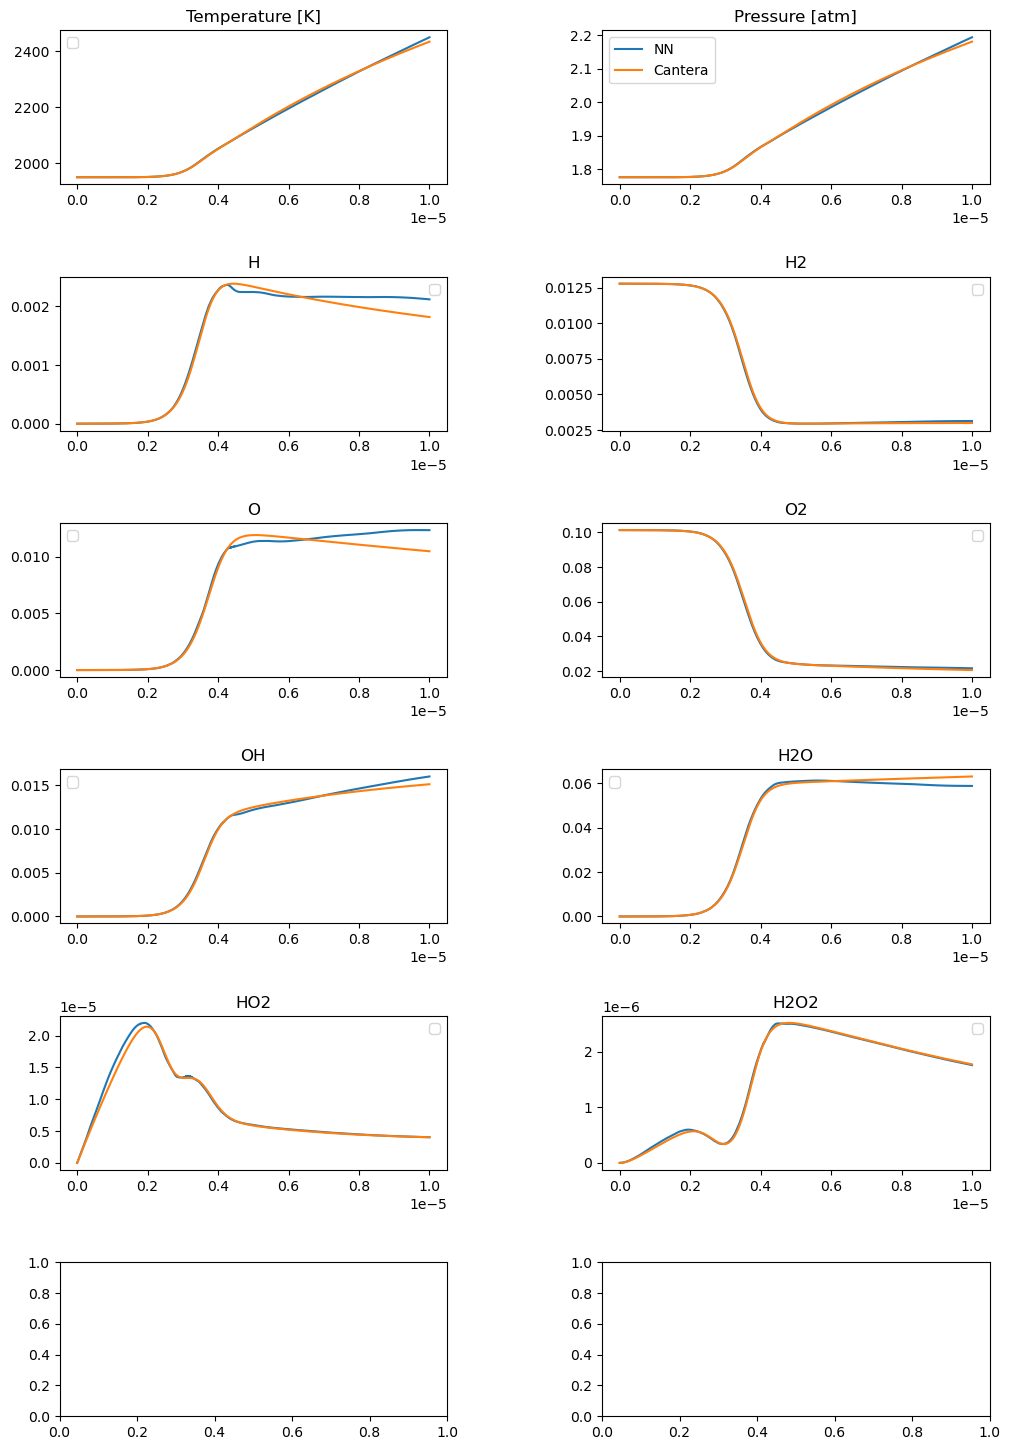

In [37]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(12, 18))  # Increase figure size
axes = axes.flatten()  # Flatten to make indexing easier

# Flatten axes array for easier indexing
axes = axes.flatten()

time = np.linspace(0, total_time_steps*1e-9, total_time_steps)
axes[0].plot(time, history_of_states[:,0])
axes[0].plot(time, x[:,1])
axes[0].set_title('Temperature [K]')
axes[0].legend()

axes[1].plot(time, history_of_states[:,1], label = "NN")
axes[1].plot(time, x[:,2], label = "Cantera")
axes[1].set_title('Pressure [atm]')
axes[1].legend()

axes[2].plot(time, history_of_states[:,2])
axes[2].plot(time, x[:,3])
axes[2].set_title('H')
axes[2].legend()

axes[3].plot(time, history_of_states[:,3])
axes[3].plot(time, x[:,4])
axes[3].set_title('H2')
axes[3].legend()


axes[4].plot(time, history_of_states[:,4])
axes[4].plot(time, x[:,5])
axes[4].set_title('O')
axes[4].legend()

axes[5].plot(time, history_of_states[:,5])
axes[5].plot(time, x[:,6])
axes[5].set_title('O2')
axes[5].legend()

axes[6].plot(time, history_of_states[:,6])
axes[6].plot(time, x[:,7])
axes[6].set_title('OH')
axes[6].legend()

axes[7].plot(time, history_of_states[:,7])
axes[7].plot(time, x[:,8])
axes[7].set_title('H2O')
axes[7].legend()

axes[8].plot(time, history_of_states[:,8])
axes[8].plot(time, x[:,9])
axes[8].set_title('HO2')
axes[8].legend()

axes[9].plot(time, history_of_states[:,9])
axes[9].plot(time, x[:,10])
axes[9].set_title('H2O2')
axes[9].legend()

fig.subplots_adjust(wspace=0.4, hspace=0.6)
plt.show()

In [80]:
#for nn5
mean_input5 = np.array([2919.4364554245954, 2.650459630025233, -5.2311709315835735, -4.088252171819475, -4.46170808746489, -2.850897566780981, -4.120616255902592, -3.485131339585899, -6.613365030486587, -7.573851436587735])
std_input5 = np.array([512.6438702993934, 1.9156705341714577, 1.011477353923571, 0.35748944253661213, 1.4118521325464723, 0.5454943439472795, 1.4977449434303534, 1.7877920682967947, 0.6397854398262626, 0.37510374702759236])
mean_output5 = np.array([-0.012065518267611236, 4.152060994339688e-06, 0.016707599303770037, -0.0003626669395628164, 0.01696693744783016, -0.000554305108856307, 0.01982642257885528, 0.017854331571357542, 0.02158795706196252, 0.01466893159907499])
std_output5 = np.array([0.17712867543683497, 0.00030732879388217175, 0.13253264369065887, 0.000830248071376656, 0.11503699815358925, 0.0012165823027967687, 0.13031205415703587, 0.10242883431331506, 0.18755669133389144, 0.10923402864763193])

nn_5 = load_model("NN5.h5") #uses ffcm2 and does not have ozone
def predict_combustion_5(input):
    input_state = np.concatenate([np.array([input[0], input[1]]), boxcox(np.maximum(input[2:], 0))])    # Box-Cox transform with lambda = 0.1 for elements from index 2 onward
    input_state = (input_state - mean_input5) / std_input5
    input_state = torch.FloatTensor(input_state.reshape(1, -1))
    model_output = nn_5(input_state)  # This function must return a shape-(11,) array-like
    output_real = model_output.numpy().flatten()

    output_real = output_real * std_output5 + mean_output5


    input_real = input_state.numpy().flatten()
    input_real = input_real * std_input + mean_input
    output_real += input_real
    output_real[2:] = np.maximum(boxcox_inv(output_real[2:]), 0)
    return output_real

input = np.array([1950, 180000/101325, 0, 0.0127722113, 0, 0.1013689888, 0, 0, 0, 0])

total_time_steps = 10000
#Change path to mechanism here as needed

history_of_states = np.zeros((total_time_steps, 10))
history_of_states[0] = input
print(input)
for i in range(1, total_time_steps):
    print(i)
    if i % 5 != 0:   #USE NN switch value here to change frequency of cantera usage. i % 10 uses cantera once every 10 timesteps
        next_state = predict_combustion_5(input)

        # Start with Ar mass fraction
        run_sum = 0.8858587999

        # Zero out negatives and accumulate the sum from index 2 to 10
        for j in range(2, 10):
            next_state[j] = max(0.0, next_state[j])
            run_sum += next_state[j]

        # Normalize elements from index 2 to 10 so total sum = 1
        for j in range(2, 10):
            next_state[j] = next_state[j] / run_sum
        history_of_states[i] = next_state


        input = next_state


    else:   #USE CANTERA
        gas = ct.Solution("FFCM2_H2_Ar.yaml")

        Ar_massfrac = 1 - (input[2] + input[3] + input[4] + input[5] + input[6] + input[7] + input[8] + input[9])
        mass_frac_list = f"H:{input[2]},H2:{input[3]},O:{input[4]},O2:{input[5]},OH:{input[6]},H2O:{input[7]},HO2:{input[8]},H2O2:{input[9]},AR:{Ar_massfrac}"
        gas.TPY = input[0], input[1] * 101325, mass_frac_list #K, Pa, massfarcs
        reactor = ct.IdealGasReactor(gas)
        network = ct.ReactorNet([reactor])
        dt = 1e-9
        x = np.zeros(11)
        #Order: "H", "H2", "O", "O2", "OH", "H2O", "HO2", "H2O2", NOT "O3", NOT "AR"
        j = 0
        network.advance(dt)
        #   x[j, 0] = network.time
        x[0] = reactor.T
        x[1] = reactor.thermo.P / 101325
        x[2] = gas.mass_fraction_dict().get('H', 0.0)
        x[3] = gas.mass_fraction_dict().get('H2', 0.0)
        x[4] = gas.mass_fraction_dict().get('O', 0.0)
        x[5] = gas.mass_fraction_dict().get('O2', 0.0)
        x[6] = gas.mass_fraction_dict().get('OH', 0.0)
        x[7] = gas.mass_fraction_dict().get('H2O', 0.0)
        x[8] = gas.mass_fraction_dict().get('HO2', 0.0)
        x[9] = gas.mass_fraction_dict().get('H2O2', 0.0)
           # x[i, 12] = gas.mass_fraction_dict().get('AR', 0.0)
        input = np.array([x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7], x[8], x[9]])
        history_of_states[i] = input

#Change path to mechanism of choice for cantera run. Use the same mechansim that was used in NN training
gas = ct.Solution("FFCM2_H2_Ar.yaml")

gas.TPX = 1950, 180000, "H2:2, O2:1, AR:7"
reactor = ct.IdealGasReactor(gas)
network = ct.ReactorNet([reactor])

# Make sure the timesteps here matches the time steps you simulated the NN for
n_steps = 10000 # Number of time steps
time_end = n_steps * 1e-9  # Convert ns to seconds

time = np.linspace(0, time_end, n_steps)

data = []
x = np.zeros((n_steps, 13))
#Order: "H", "H2", "O", "O2", "OH", "H2O", "HO2", "H2O2", "O3", NOT "AR"
i = 0
for t in time:
    network.advance(t)
    x[i, 0] = network.time
    x[i, 1] = reactor.T
    x[i, 2] = reactor.thermo.P / 101325
    x[i, 3] = gas.mass_fraction_dict().get('H', 0.0)
    x[i, 4] = gas.mass_fraction_dict().get('H2', 0.0)
    x[i, 5] = gas.mass_fraction_dict().get('O', 0.0)
    x[i, 6] = gas.mass_fraction_dict().get('O2', 0.0)
    x[i, 7] = gas.mass_fraction_dict().get('OH', 0.0)
    x[i, 8] = gas.mass_fraction_dict().get('H2O', 0.0)
    x[i, 9] = gas.mass_fraction_dict().get('HO2', 0.0)
    x[i, 10] = gas.mass_fraction_dict().get('H2O2', 0.0)
    x[i, 11] = gas.mass_fraction_dict().get('O3', 0.0)
    x[i, 12] = gas.mass_fraction_dict().get('AR', 0.0)
    i = i+1

[1.95000000e+03 1.77646188e+00 0.00000000e+00 1.27722113e-02
 0.00000000e+00 1.01368989e-01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
23

/var/folders/n_/rcf8wz2n2dn4lpt0vg476ky00000gn/T/ipykernel_12566/3532180329.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend()
/var/folders/n_/rcf8wz2n2dn4lpt0vg476ky00000gn/T/ipykernel_12566/3532180329.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[2].legend()
/var/folders/n_/rcf8wz2n2dn4lpt0vg476ky00000gn/T/ipykernel_12566/3532180329.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[3].legend()
/var/folders/n_/rcf8wz2n2dn4lpt0vg476ky00000gn/T/ipykernel_12566/3532180329.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with

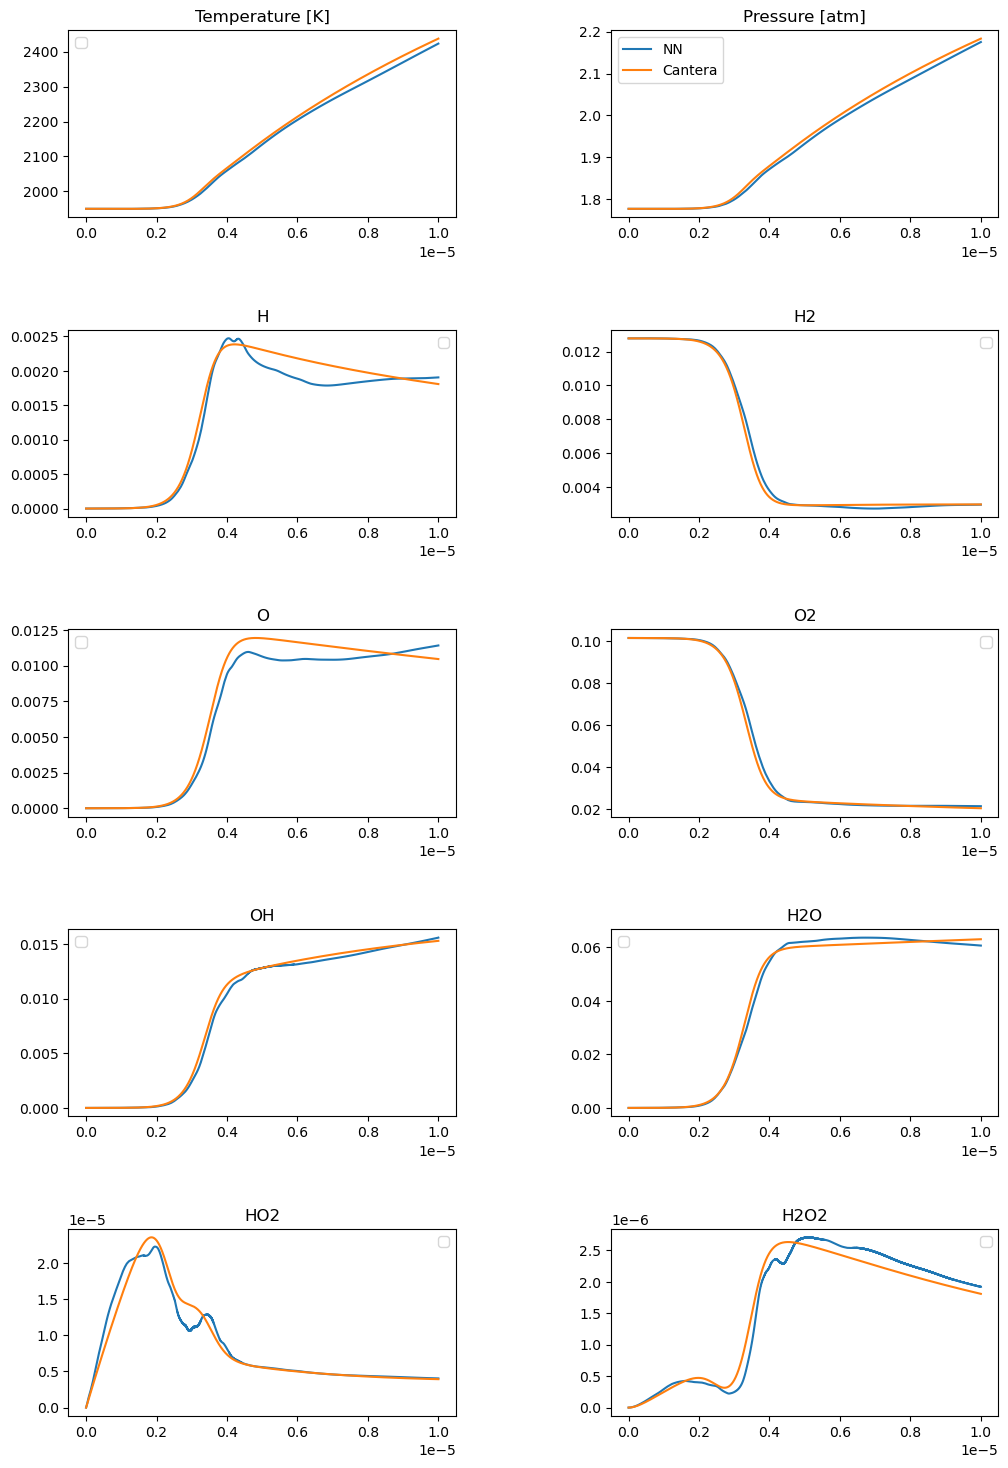

In [45]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 18))  # Increase figure size
axes = axes.flatten()  # Flatten to make indexing easier

# Flatten axes array for easier indexing
axes = axes.flatten()

time = np.linspace(0, total_time_steps*1e-9, total_time_steps)
axes[0].plot(time, history_of_states[:,0])
axes[0].plot(time, x[:,1])
axes[0].set_title('Temperature [K]')
axes[0].legend()

axes[1].plot(time, history_of_states[:,1], label = "NN")
axes[1].plot(time, x[:,2], label = "Cantera")
axes[1].set_title('Pressure [atm]')
axes[1].legend()

axes[2].plot(time, history_of_states[:,2])
axes[2].plot(time, x[:,3])
axes[2].set_title('H')
axes[2].legend()

axes[3].plot(time, history_of_states[:,3])
axes[3].plot(time, x[:,4])
axes[3].set_title('H2')
axes[3].legend()


axes[4].plot(time, history_of_states[:,4])
axes[4].plot(time, x[:,5])
axes[4].set_title('O')
axes[4].legend()

axes[5].plot(time, history_of_states[:,5])
axes[5].plot(time, x[:,6])
axes[5].set_title('O2')
axes[5].legend()

axes[6].plot(time, history_of_states[:,6])
axes[6].plot(time, x[:,7])
axes[6].set_title('OH')
axes[6].legend()

axes[7].plot(time, history_of_states[:,7])
axes[7].plot(time, x[:,8])
axes[7].set_title('H2O')
axes[7].legend()

axes[8].plot(time, history_of_states[:,8])
axes[8].plot(time, x[:,9])
axes[8].set_title('HO2')
axes[8].legend()

axes[9].plot(time, history_of_states[:,9])
axes[9].plot(time, x[:,10])
axes[9].set_title('H2O2')
axes[9].legend()

fig.subplots_adjust(wspace=0.4, hspace=0.6)
plt.show()

In [13]:
#!python3
import numpy as np
import cantera as ct
import matplotlib.pyplot as plt
gas = ct.Solution("FFCM2_H2_AR.yaml")

def inverse_3x3(A):
    A = np.asarray(A)
    if A.shape != (3, 3):
        raise ValueError("Matrix must be 3x3.")

    # Compute the determinant
    det = (
        A[0, 0] * (A[1, 1]*A[2, 2] - A[1, 2]*A[2, 1]) -
        A[0, 1] * (A[1, 0]*A[2, 2] - A[1, 2]*A[2, 0]) +
        A[0, 2] * (A[1, 0]*A[2, 1] - A[1, 1]*A[2, 0])
    )

    if abs(det) < 1e-12:
        raise ValueError("Matrix is singular or nearly singular.")

    # Compute cofactor matrix
    cof = np.zeros((3, 3))
    cof[0, 0] = +(A[1, 1]*A[2, 2] - A[1, 2]*A[2, 1])
    cof[0, 1] = -(A[1, 0]*A[2, 2] - A[1, 2]*A[2, 0])
    cof[0, 2] = +(A[1, 0]*A[2, 1] - A[1, 1]*A[2, 0])
    cof[1, 0] = -(A[0, 1]*A[2, 2] - A[0, 2]*A[2, 1])
    cof[1, 1] = +(A[0, 0]*A[2, 2] - A[0, 2]*A[2, 0])
    cof[1, 2] = -(A[0, 0]*A[2, 1] - A[0, 1]*A[2, 0])
    cof[2, 0] = +(A[0, 1]*A[1, 2] - A[0, 2]*A[1, 1])
    cof[2, 1] = -(A[0, 0]*A[1, 2] - A[0, 2]*A[1, 0])
    cof[2, 2] = +(A[0, 0]*A[1, 1] - A[0, 1]*A[1, 0])

    # Transpose of cofactor matrix = adjugate
    adj = cof.T

    # Inverse = adjugate / determinant
    return adj / det

def reference_solution(gas, initial_conditions):
    gas.TPX  = initial_conditions
    reactor = ct.IdealGasReactor(gas)
    network = ct.ReactorNet([reactor])

    n_steps = int(50000)
    dt = 1e-9
    time_end = n_steps * dt

    time = np.linspace(0, time_end, n_steps)

    temperature = []
    
    for t in time:
        network.advance(t)
        T = reactor.T
        temperature.append(T)

    temperature = np.array(temperature)
    return time, temperature

def sum_target(larger_array, indexes):
    return sum(val for i, val in enumerate(larger_array) if i not in indexes)

def free_parameter_solve(gas, initial_conditions, free_species = ["OH", "H2O", "O"]):
    gas.TPX  = initial_conditions
    idx_a = gas.species_index(free_species[0])
    idx_b = gas.species_index(free_species[1])
    idx_c = gas.species_index(free_species[2])
    indexes = [idx_a, idx_b, idx_c]
    MW = gas.molecular_weights

    reactor = ct.IdealGasReactor(gas)
    network = ct.ReactorNet([reactor])

    n_steps = int(50000)
    time_end = n_steps * 1e-9
    dt = time_end/n_steps
    time_end = n_steps * dt

    time = np.linspace(0, time_end, n_steps)

    temperature = []
    for t in time:
        #get conserverd variables
        density = reactor.thermo.density
        internal_energy_volume_specific = density * reactor.thermo.int_energy_mass  # [J/m³]
        print(internal_energy_volume_specific)
        network.advance(t)
        #T = reactor.T
        #temperature.append(T)
            # Access the current state
        T = reactor.T
        P = reactor.thermo.P
        Y = reactor.thermo.Y
        input = np.array([gas.T, gas.P/101325, gas.mass_fraction_dict().get('H', 0.0), gas.mass_fraction_dict().get('H2', 0.0), gas.mass_fraction_dict().get('O', 0.0), gas.mass_fraction_dict().get('O2', 0.0), gas.mass_fraction_dict().get('OH', 0.0), gas.mass_fraction_dict().get('H2O', 0.0), gas.mass_fraction_dict().get('HO2', 0.0), gas.mass_fraction_dict().get('H2O2', 0.0)])
        next_state = predict_combustion_5(input)
        # Start with Ar mass fraction
        run_sum = 0.8858587999
        # Zero out negatives and accumulate the sum from index 2 to 10
        for j in range(2, 10):
            next_state[j] = max(0.0, next_state[j])
            run_sum += next_state[j]
        # Normalize elements from index 2 to 10 so total sum = 1
        for j in range(2, 10):
            next_state[j] = next_state[j] / run_sum
        T = next_state[0]
        temperature.append(T)
            # Access the current state
        P = next_state[1]
        Y = next_state[2:]
        
        Y_with_Ar = np.append(Y, 0.8858587999)
        B1 = 1 - sum_target(Y, indexes)
        B2 = P/ct.gas_constant/T/density - sum_target(Y_with_Ar/MW, indexes)
        mass_frac_list = f"H:{input[2]},H2:{input[3]},O:{input[4]},O2:{input[5]},OH:{input[6]},H2O:{input[7]},HO2:{input[8]},H2O2:{input[9]},AR:0.8858587999"
        gas.TPY = input[0], input[1] * 101325, mass_frac_list #K, Pa, massfarcs
        u_i  = gas.standard_int_energies_RT * ct.gas_constant * reactor.T/MW
        B3 = (internal_energy_volume_specific - density * sum_target(Y_with_Ar * u_i, indexes))/density

        A = np.array([[1,1,1],[1/MW[idx_a], 1/MW[idx_b], 1/MW[idx_c]],[u_i[idx_a], u_i[idx_b], u_i[idx_c]]])
        B = np.array([B1, B2, B3])
        Y_new = inverse_3x3(A) @ B 

        # Slightly modify species (e.g., reduce H2 a bit)
        Y_mod = Y.copy()
        Y_mod[idx_a] = Y_new[0]
        Y_mod[idx_b] = Y_new[1]
        Y_mod[idx_c] = Y_new[2]

        Y_mod /= Y_mod.sum()     # re-normalize to keep sum = 1
        input = np.array([T, P, Y_mod[0], Y_mod[1], Y_mod[2], Y_mod[3], Y_mod[4], Y_mod[5], Y_mod[6], Y_mod[7]])
    # Apply the new state
        reactor.thermo.TPY = T, P, np.append(Y_mod, 0.8858587999)
        reactor.syncState()
    temperature = np.array(temperature)
    return time, temperature

initial_conditions = 1950, 180000, "AR:7, H2:2, O2:1"
time, temperature = reference_solution(gas, initial_conditions)
time_fp, temperature_fp = free_parameter_solve(gas, initial_conditions)

plt.plot(time, temperature, '-k')
plt.plot(time_fp, temperature_fp, '-r')
plt.legend(["Cantera", "NN"])
plt.show()


CanteraError: 
*******************************************************************************
CanteraError thrown by Application::findInputFile:

Input file FFCM2_H2_AR.yaml not found in directories 
'.', 
'/opt/miniconda3/envs/nn_environment/lib/python3.9/site-packages/cantera/data', 
'/opt/miniconda3/envs/nn_environment/share/cantera/data', 
'/opt/miniconda3/envs/nn_environment/share/cantera/data'

To fix this problem, either:
    a) move the missing files into the local directory;
    b) define environment variable CANTERA_DATA to
         point to the directory containing the file.
*******************************************************************************
